In [1]:
# Google Drive 연동
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load Packages
from IPython import display

import os
from tqdm import tqdm
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
import time

In [14]:
# Load Dataset
def find_path(path):
    file_list = os.listdir(path)
    return file_list

def png_to_np(path, file_list, read_type='rgb'):
    pix = []
    for idx in tqdm(range(len(file_list))):
      file_name = file_list[idx]
      if read_type == "rgb":
        image = PIL.Image.open(path + '/' + file_name) # (256, 256, 3)
      elif read_type == "gray":
        image = PIL.Image.open(path + '/' + file_name).convert("L") # (256, 256, 1)
      np_image = (np.array(image).astype(np.float32) - 127.5) / 127.5
      pix.append(np_image)
    return pix

In [15]:
#데이터셋 받는부분
image_size = 128
channel = 1
read_type = lambda channel: 'rgb' if channel==3 else 'gray'
batch_size = 64
train_size = 768  #616 #10 
test_size =  130  #154 #2  

path = 'drive/MyDrive/dataset/pockemon/jpg/jpg_dataset_{}'.format(str(image_size))  # 'drive/MyDrive/dataset/Dobby/Dobby_{}' # 'drive/MyDrive/dataset/Human/Human_{}'

file_list = find_path(path)
images = png_to_np(path, file_list, read_type=read_type(channel))

train_dataset = np.array(images[:train_size])
test_dataset = np.array(images[train_size:])

# GrayScale일때 1channel을 만들어주기위해 활용
if channel == 1:
  train_dataset = train_dataset[..., tf.newaxis]
  test_dataset = test_dataset[..., tf.newaxis]

print(train_dataset.shape, test_dataset.shape)

#train_dataset = (tf.data.Dataset.from_tensor_slices(train_dataset)
#                 .shuffle(train_size).batch(batch_size))
#test_dataset = (tf.data.Dataset.from_tensor_slices(test_dataset)
#                .shuffle(test_size).batch(batch_size))

100%|██████████| 898/898 [07:01<00:00,  2.13it/s]

(768, 128, 128, 1) (130, 128, 128, 1)


In [ ]:
# MNIST 데이터셋 받는부분
mnist = tf.keras.datasets.mnist

# (훈련 이미지, 훈련 레이블), (시험 이미지, 시험 레이블)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

train_dataset = x_train[..., tf.newaxis]
test_dataset = x_test[..., tf.newaxis]

#train_dataset = train_dataset.reshape(60000, 784)
#test_dataset = test_dataset.reshape(10000, 784)

# Normal Auto Encoder Architecture

In [16]:
leakyrelu = tf.keras.layers.LeakyReLU()
conv2d = tf.keras.layers.Conv2D
conv2d_t = tf.keras.layers.Conv2DTranspose
flatten = tf.keras.layers.Flatten
dense = tf.keras.layers.Dense
reshape = tf.keras.layers.Reshape

a_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

# encoder
a_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_input_img)   # 128 -> 64 
a_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_encoder1)    # 64 -> 32
#encoder3 = conv2d(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder2)   # 32 -> 16  
#encoder4 = conv2d(256, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder3)   # 16 -> 8

a_flatten = flatten()(a_encoder2)
a_dense1 = dense(10, activation=leakyrelu)(a_flatten)
a_dense2 = dense(int(image_size/4) * int(image_size/4) * 64, activation=leakyrelu)(a_dense1)
#dense3 = dense(8 * 8 * 256, activation='sigmoid')(dense2)
#dense4 = dense(8 * 8 * 256, activation='sigmoid')(dense3)

a_reshape = reshape(target_shape=(int(image_size/4), int(image_size/4), 64), input_shape=(a_dense2,))(a_dense2)
# decoder
#decoder1 = conv2d_t(128, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(encoder4) 
#decoder2 = conv2d_t(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(decoder1) 
a_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(a_reshape)
a_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(a_decoder1)

autoencoder = tf.keras.Model(inputs=a_input_img, outputs=a_decoder2)

In [17]:
leakyrelu = tf.keras.layers.LeakyReLU()
conv2d = tf.keras.layers.Conv2D
conv2d_t = tf.keras.layers.Conv2DTranspose
flatten = tf.keras.layers.Flatten
dense = tf.keras.layers.Dense
reshape = tf.keras.layers.Reshape

g_input_img = tf.keras.Input(shape=(image_size, image_size, 1))

# encoder
g_encoder1 = conv2d(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_input_img)
g_encoder2 = conv2d(64, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_encoder1)

g_decoder1 = conv2d_t(32, kernel_size=(2, 2), strides=2, activation=leakyrelu, padding="same")(g_encoder2)
g_decoder2 = conv2d_t(1, kernel_size=(2, 2), strides=2, padding="same")(g_decoder1)

generator = tf.keras.Model(inputs=g_input_img, outputs=g_decoder2)

In [18]:
autoencoder.summary(), generator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 32)        160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        8256      
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                655370    
_________________________________________________________________
dense_3 (Dense)              (None, 65536)             720896    
_________________________________________________________________
reshape_1 (Reshape)          (None, 32, 32, 64)        0   

(None, None)

In [19]:
autoencoder.compile(optimizer='adam', loss='MSE')
autoencoder.fit(train_dataset, train_dataset,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(test_dataset, test_dataset))

print('auto encoder train finish')

Epoch 1/100
12/12 [==============================] - 1s 32ms/step - loss: 0.5909 - val_loss: 0.3264
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.2113 - val_loss: 0.1995
Epoch 3/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1721 - val_loss: 0.1812
Epoch 4/100
12/12 [==============================] - 0s 19ms/step - loss: 0.1639 - val_loss: 0.1743
Epoch 5/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1611 - val_loss: 0.1734
Epoch 6/100
12/12 [==============================] - 0s 19ms/step - loss: 0.1603 - val_loss: 0.1729
Epoch 7/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1600 - val_loss: 0.1727
Epoch 8/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1599 - val_loss: 0.1722
Epoch 9/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1594 - val_loss: 0.1719
Epoch 10/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1585 - val_loss: 0.1698

In [ ]:
# Noise 생성부
noises = []

for i in range(test_size):
  noise = tf.random.normal((image_size, image_size), mean=0.0, stddev=1.0, dtype=tf.dtypes.float32, seed=None, name=None) 
  noise = noise[..., tf.newaxis]
  noises.append(noise)

noises = np.array(noises)

print(noises.shape)

(2, 128, 128, 1)


In [20]:
# Feature Map 생성부
g_train_dataset = autoencoder.predict(train_dataset)
g_test_dataset = autoencoder.predict(test_dataset)

In [21]:
# Generator 학습
generator.compile(optimizer='adam', loss='MSE')
generator.fit(g_train_dataset, train_dataset,
              epochs=100,
              batch_size=64,
              shuffle=True,
              validation_data=(g_test_dataset, test_dataset))

print('generator train finish')

Epoch 1/100
12/12 [==============================] - 1s 27ms/step - loss: 0.7047 - val_loss: 0.6253
Epoch 2/100
12/12 [==============================] - 0s 19ms/step - loss: 0.4575 - val_loss: 0.2586
Epoch 3/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1599 - val_loss: 0.1614
Epoch 4/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1174 - val_loss: 0.1440
Epoch 5/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1083 - val_loss: 0.1372
Epoch 6/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1047 - val_loss: 0.1345
Epoch 7/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1033 - val_loss: 0.1340
Epoch 8/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1026 - val_loss: 0.1329
Epoch 9/100
12/12 [==============================] - 0s 17ms/step - loss: 0.1021 - val_loss: 0.1326
Epoch 10/100
12/12 [==============================] - 0s 18ms/step - loss: 0.1017 - val_loss: 0.1320

In [22]:
# Noise + Feature Map 생성부
import random

# 13개의 난수 생성
randoms = []
for i in range(160):
  random_value = random.randint(0, image_size ** 2)
  randoms.append(random_value)

# test Dataset을 활용하여 Feature Map 추출
reconstructed_imgs = autoencoder.predict(test_dataset)
reconstructed_imgs.shape
noisealization_imgs = []

# 추출된 FeatureMap에 Noise를 넣어줌
for image in reconstructed_imgs:
  # 1차원으로 reshpae
  image = tf.reshape(image, (-1, 1))
  image = image.numpy()

  # 1차원으로 reshape된 이미지에 난수와 동일한 index를 만나면 해당값을 Random값으로 변환
  for idx, i in enumerate(image):
    if idx in randoms:
      ranfloat = random.uniform(0., 1.0)
      image[idx] = ranfloat

  # Noise가 섞인 이미지는 다시 원래 사이즈로 돌려놓고 새로운 리스트에 넣어줌
  image = image.reshape(image_size, image_size, 1)
  noisealization_imgs.append(image)

# 기존 shape와 동일하게 나옴
noisealization_imgs = np.array(noisealization_imgs)

# Generator로 Output 생성
predict_imgs = generator.predict(noisealization_imgs)

if channel == 3:
  reconstructed_imgs = (np.array(reconstructed_imgs) * 255).astype(np.int64)

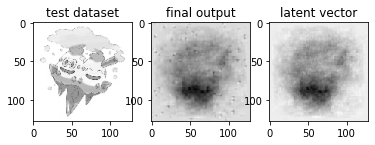

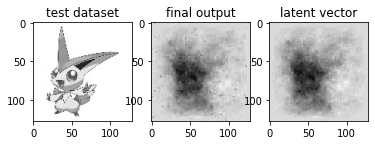

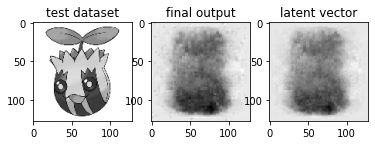

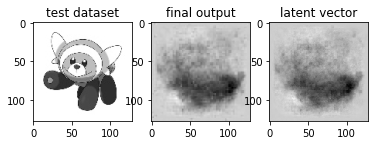

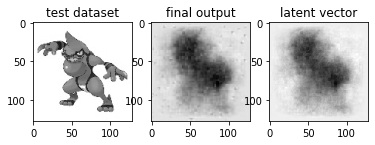

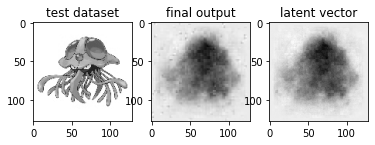

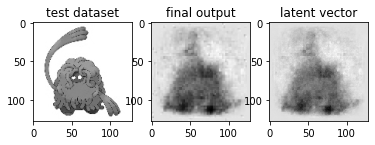

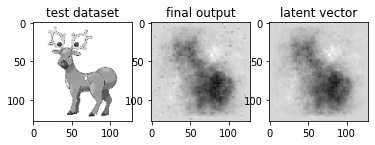

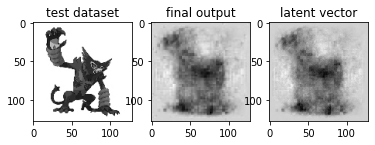

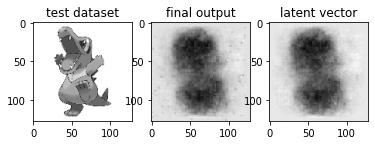

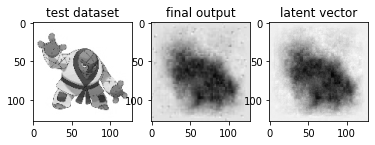

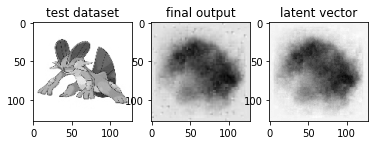

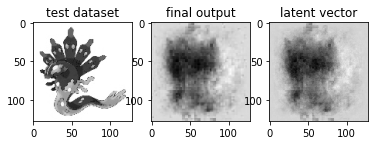

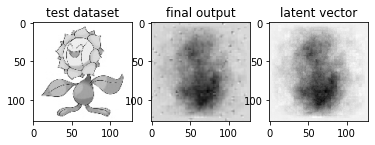

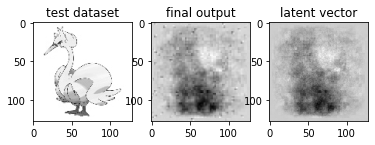

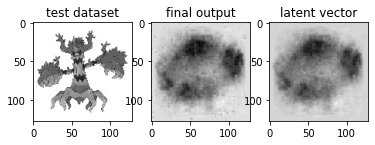

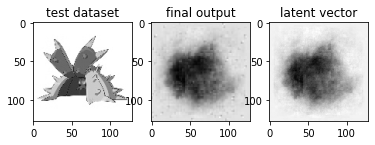

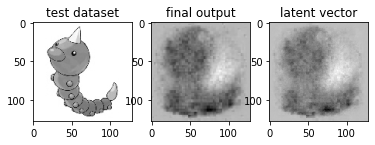

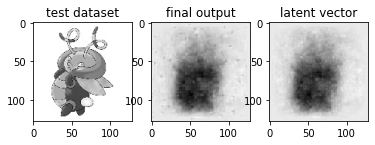

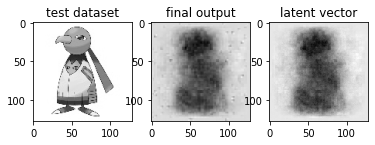

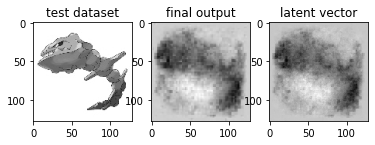

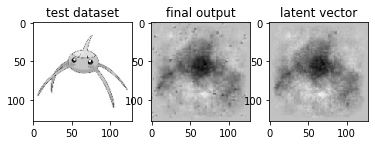

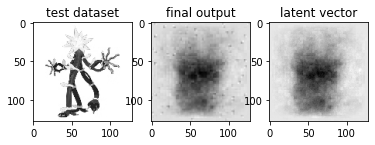

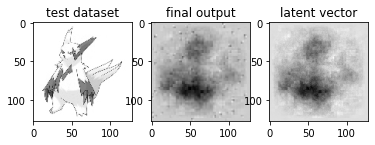

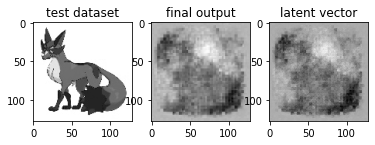

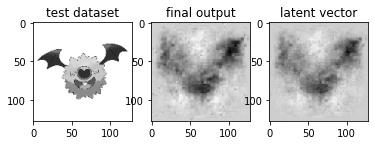

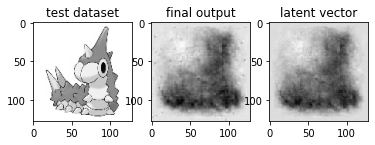

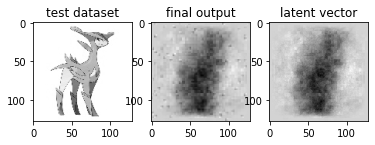

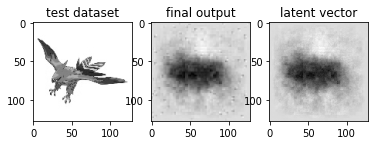

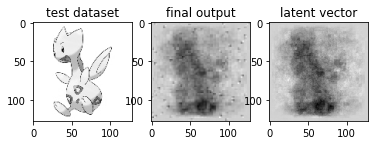

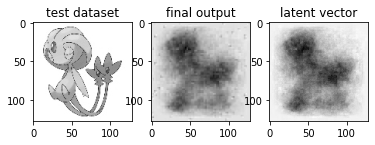

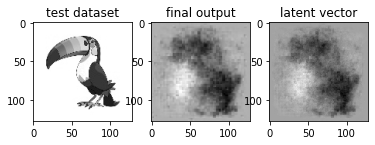

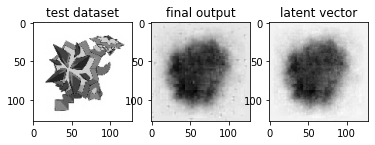

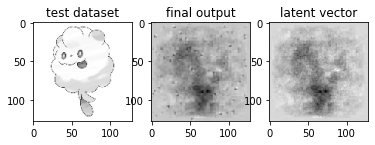

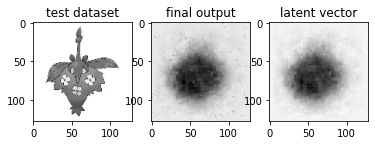

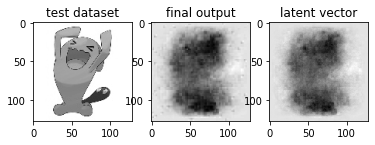

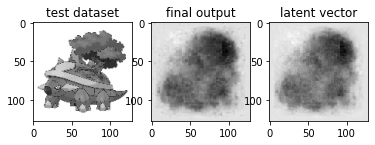

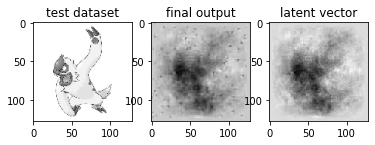

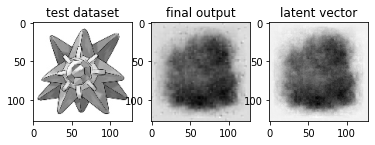

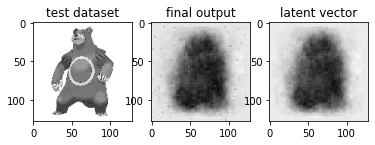

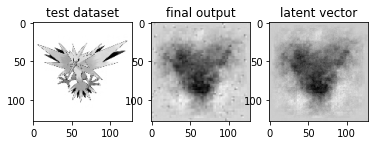

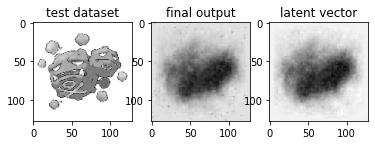

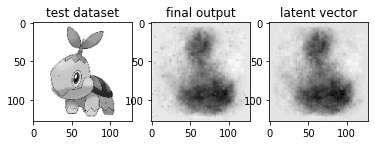

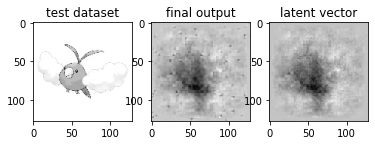

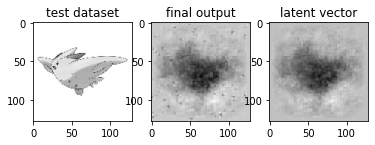

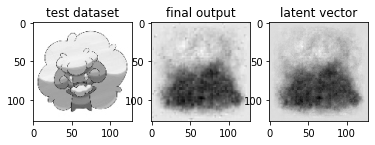

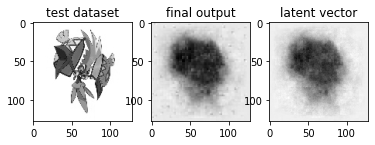

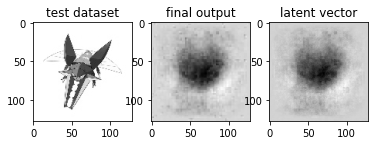

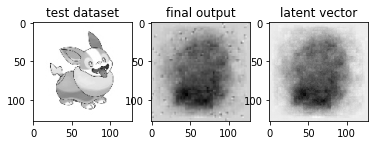

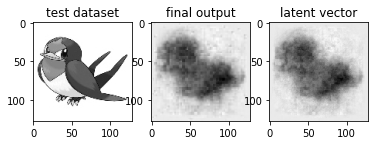

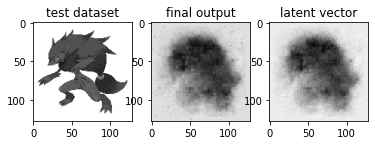

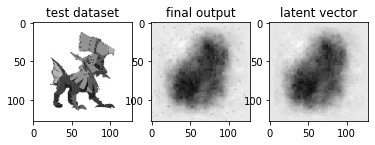

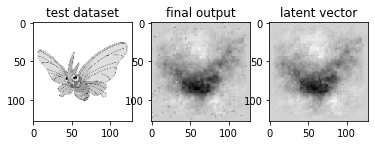

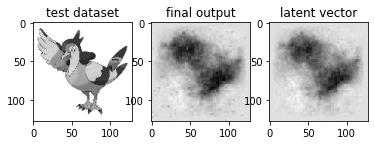

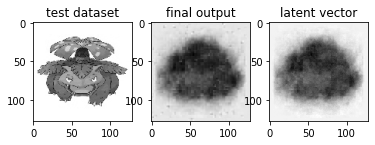

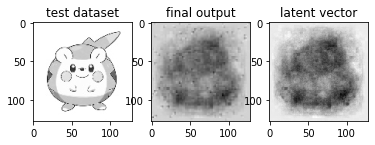

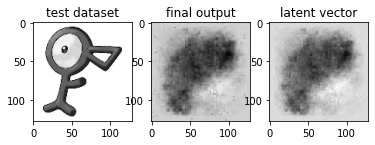

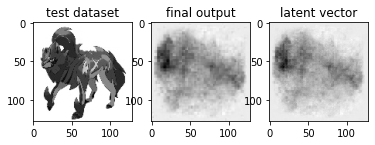

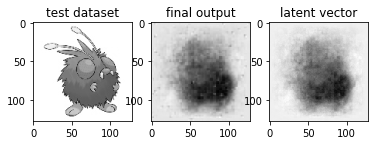

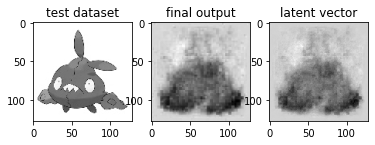

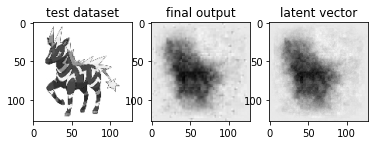

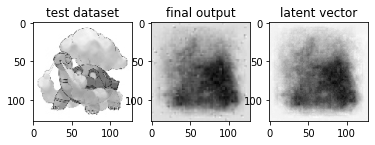

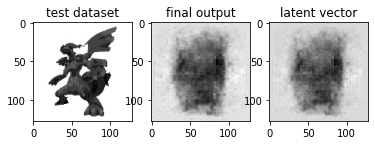

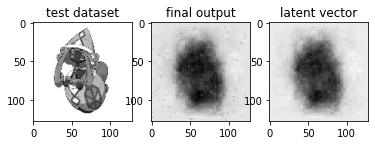

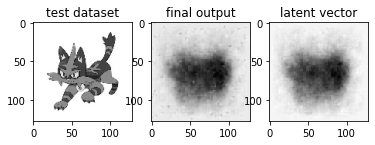

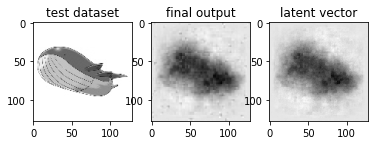

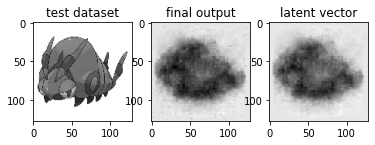

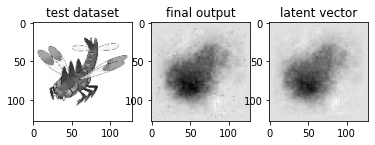

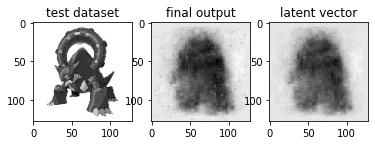

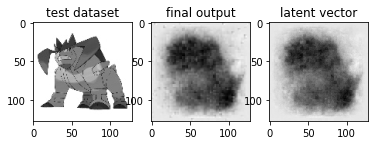

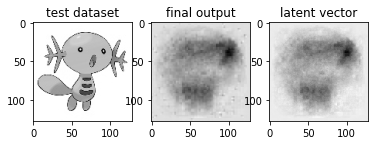

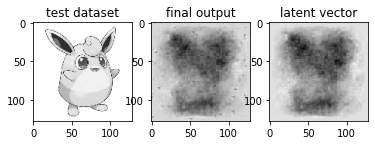

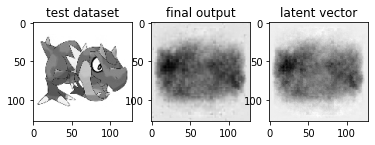

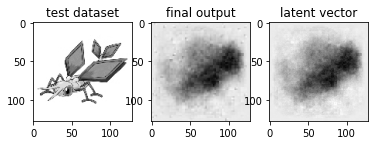

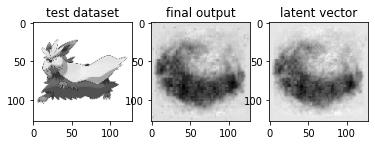

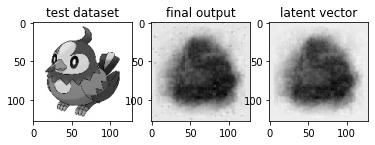

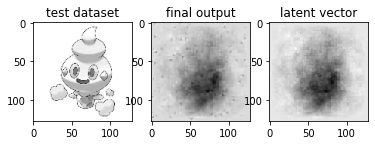

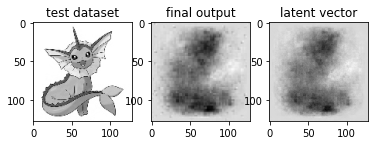

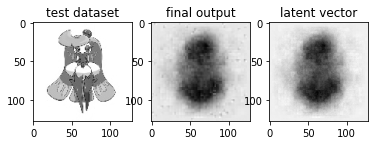

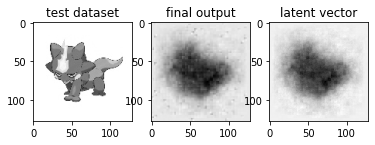

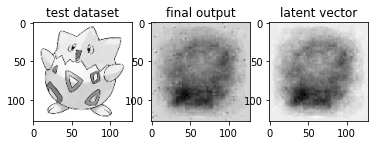

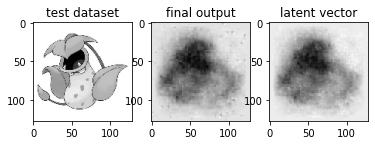

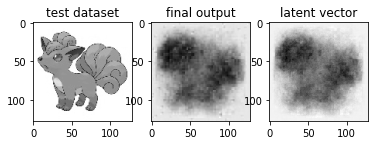

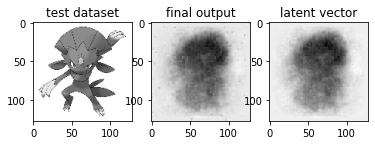

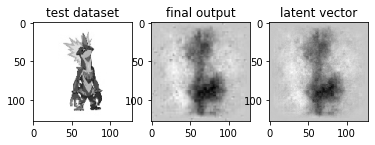

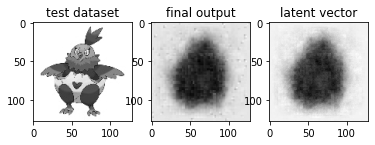

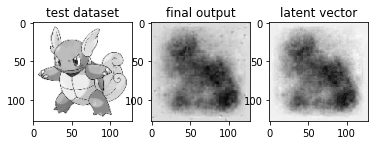

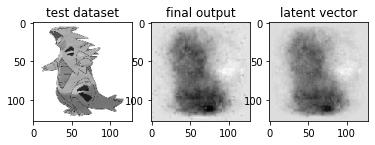

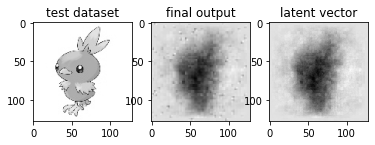

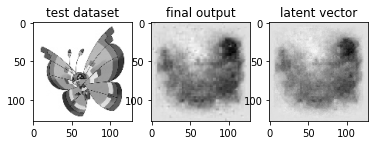

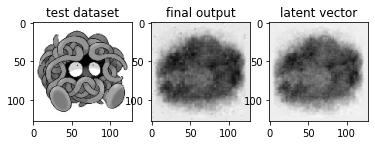

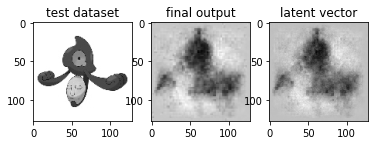

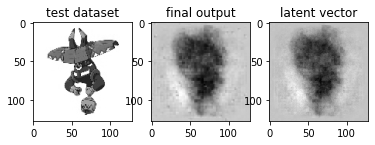

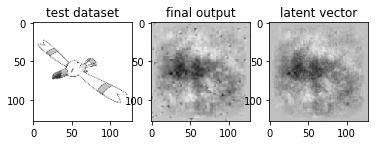

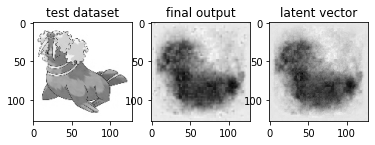

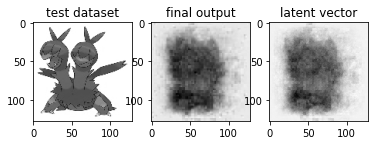

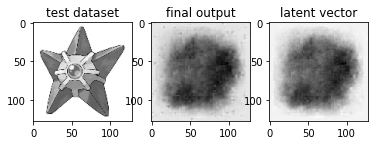

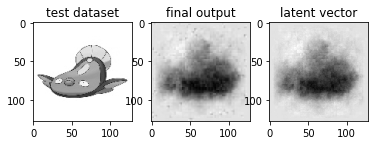

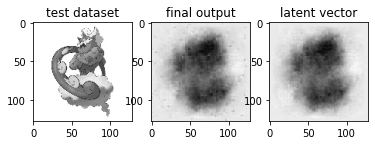

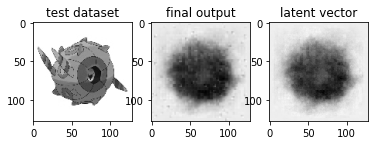

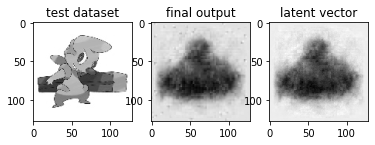

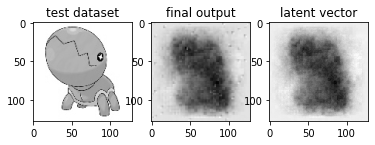

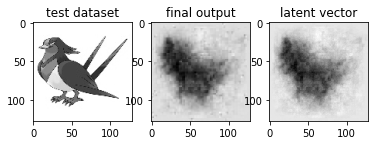

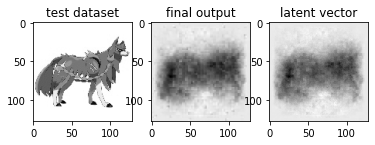

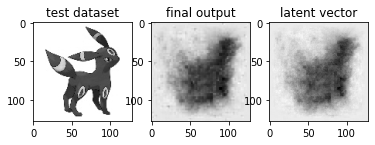

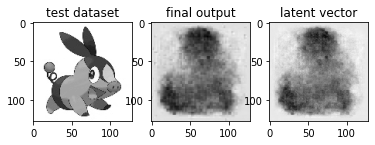

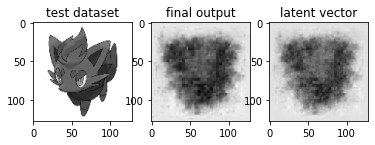

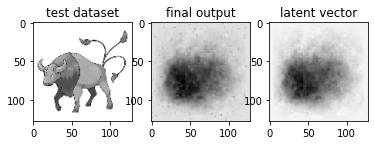

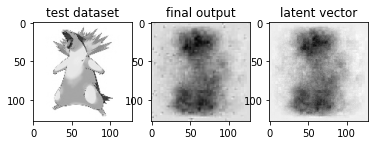

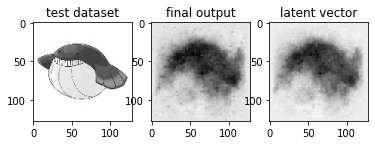

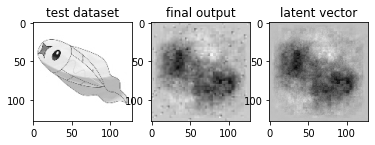

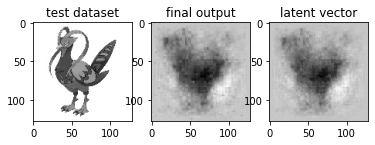

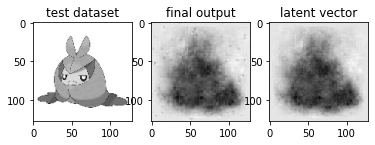

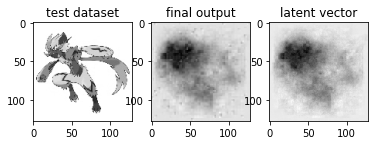

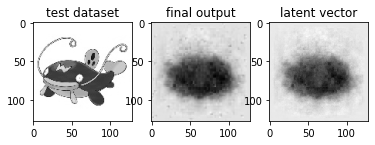

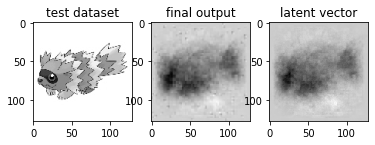

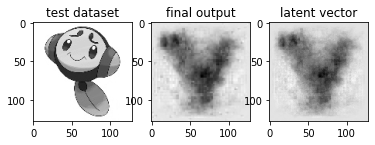

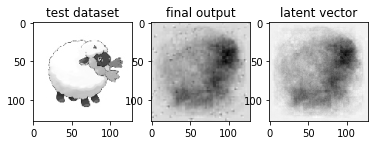

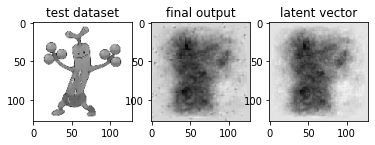

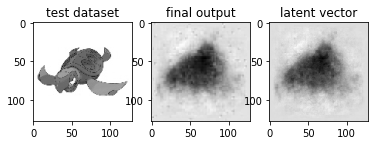

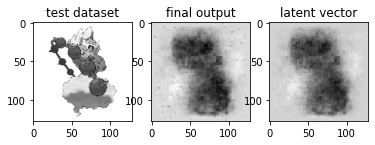

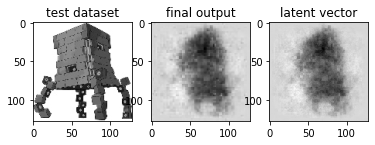

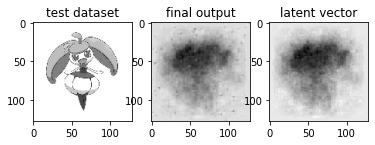

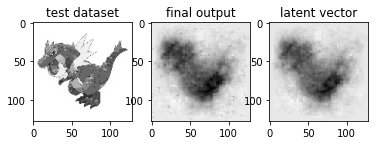

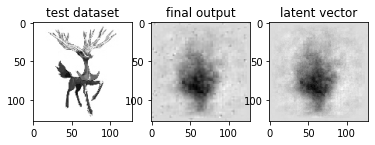

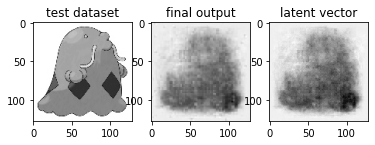

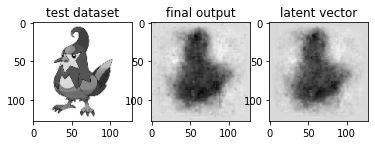

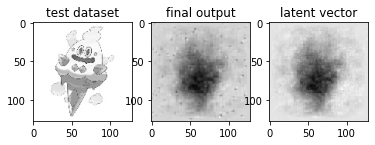

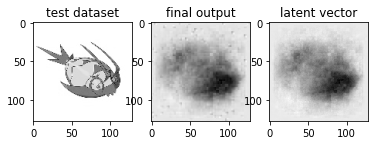

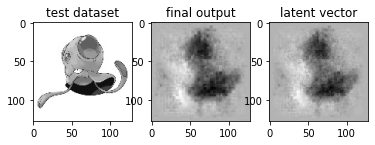

In [23]:
rgb_size = (image_size, image_size, 3)
gray_size = (image_size, image_size)
epochs = len(test_dataset)  # how many digits we will display

for i in range(epochs):
    plt.subplot(131)
    plt.title('test dataset')
    # display original
    if channel == 1:
      plt.imshow(test_dataset[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(test_dataset[i].reshape(rgb_size))

    plt.subplot(132)
    plt.title('final output')
    # display original
    if channel == 1:
      plt.imshow(predict_imgs[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(predict_imgs[i].reshape(rgb_size))

    # display reconstructed image
    plt.subplot(133)
    plt.title('latent vector')
    if channel == 1:
      plt.imshow(reconstructed_imgs[i].reshape(gray_size), cmap='gray')
    else:
      plt.imshow(reconstructed_imgs[i].reshape(rgb_size))
    plt.show()